# Topic Modeling

In [1]:
import copy
import logging
import operator
import warnings
import pandas as pd
import numpy as np
import pyLDAvis.gensim

from pprint import pprint
from gensim.test.utils import datapath

from data_loader import DataLoader
from data_utils import get_time_bins
from pre_processing import PreProcessing
from topic_modeling_gensim import TopicModeling

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/phosseini/anaconda3/envs/corona/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/phosseini/anaconda3/envs/corona/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/phosseini/anaconda3/envs/corona/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/phosseini/anaconda3/envs/corona/lib/pytho

### [1] Pre processing tweets
* Before starting the analysis, make sure all the `json` or `xlsx` files are in the following path: `data/input`

In this step, we preprocess the input full json/excel files to create cleaned tweets' collection. Cleaned tweets will be put in the `data/cleaned` folder in excel (.xlsx) format.

In [2]:
# `save_checkpoint` specifies the number of records in each cleaned excel file to avoid having very large files
PreProcessing().clean_data_json(save_checkpoint=50000)

### [2] (optional step) Finding the number of topics: Topic coherence
Now that we have cleaned tweets, we need to find the best number of topics for LDA topic modeling. Run the following cell to see the coherence score for different values of k, number of topics. 

Running the following cell may take a few minutes depending on how large the corpus is. We use the `LdaMulticore` to use multiple CPU cores to expedite the process. Also, if you want to use `Mallet`, simply set the `use_mallet=True` when calling the `TopicModeling` class.

Number of unique tokens: 406
Number of documents: 1000
2: -11.680359473189796
3: -12.28990510019724
4: -12.779820053075351
5: -12.892183329169544
6: -13.54828696284145
7: -13.88463830426529
8: -14.133136758267568
9: -14.13114863618157
10: -14.561292048935389
11: -15.00559779503581
12: -14.599619737724316
13: -15.264750199012516
14: -15.154158090355235
15: -15.425918622531103
16: -15.333153386190514
17: -15.352780073672326
18: -15.497973929393147
19: -15.654179627151542
20: -15.727766270787882
21: -15.773886486854238
22: -15.946982493217265
23: -16.00567447318549
24: -15.86741864828078
25: -15.713121435186054
26: -15.843609950261115
27: -15.612538626492896
28: -16.054590685707506
29: -16.424001340698048


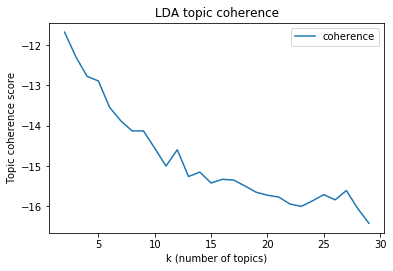

In [2]:
TopicModeling(cpu_count=3).find_topics_count()

## [3] Topic modeling

In [2]:
# creating dictionary and corpus
dictionary, corpus = TopicModeling(use_mallet=True, cpu_count=3, n_count=10000000).create_corpus()

Number of unique tokens: 43639
Number of documents: 530249


### [3.1] MALLET LDA

In [3]:
# creating the LDA model
train_model_flag = False  # True, if want to create a new model, False, if loading the existing model
n_cpu = 3
k = 100

if train_model_flag:
    coherence, lda = TopicModeling(use_mallet=True, cpu_count=n_cpu).learn_lda_model(corpus, dictionary, k)

    # Save model to disk
    model_file = datapath("mallet.model")
    lda.save(model_file)
else:
    # Load the pretrained model from disk
    lda = LdaModel.load(temp_file)

100: -5.1562463419079725


### Document-level topic distribution
Every document is a distribution/mixture of topics in the LDA model. In this part, we get the largest association value among topics associated with a document as the dominant topic of the document. Then, we do this for all documents in the corpus. In this way, we get an understanding of the topic distribution over the entire corpus.

#### 1. reading all raw docs from LDA corpus

In [4]:
print("doc topic: {}".format(lda.fdoctopics()))
print("mallet-formatted corpus: {}".format(lda.fcorpusmallet()))
print("text corpus: {}".format(lda.fcorpustxt()))
print("word weights: {}".format(lda.fwordweights()))

# loading docs
all_docs = pd.read_csv(lda.fcorpustxt(), header=None)

doc topic: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8c972f_doctopics.txt
mallet-formatted corpus: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8c972f_corpus.mallet
text corpus: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8c972f_corpus.txt
word weights: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8c972f_wordweights.txt


#### 2. finding dominant LDA topic for documents 

In [5]:
df_col = ["doc", "topic", "dist"]
df = pd.DataFrame(columns=df_col)

# loading docs * topics matrix
docs_topics = lda.load_document_topics()


idx = 0
for topics in docs_topics:
    doc_topics = pd.DataFrame(topics)
    topic_id = doc_topics[1].idxmax()
    topic_dist = doc_topics.iloc[topic_id][1]
    df = df.append({"doc": all_docs.iloc[idx][0], "topic": topic_id, "dist": topic_dist}, ignore_index=True)
    idx += 1
    if idx % 50000 == 0:
        print("check point: {}".format(idx))

# saving data frame into file
df.to_excel("data/doc_top_dist.xlsx")

check point: 50000
check point: 100000
check point: 150000
check point: 200000
check point: 250000
check point: 300000
check point: 350000
check point: 400000
check point: 450000
check point: 500000


#### 3. listing most associated documents for top topics

In [51]:
# parameters
top_n_topics = 20  # number of top distributed topics in LDA model
top_n_doc = 40  # number of top associated documents with each top topic

# ====================================================================
# group topics by count
counts_df = df.groupby(df["topic"]).size().reset_index(name='count')

# sort topics in descending order of count
counts_df = counts_df.sort_values(by=["count"], ascending=False)

# getting IDs of top topics
top_topics_ids = []
top_topics_dist = []

for i in range(top_n_topics):
    top_topics_ids.append(counts_df.iloc[i][0])
    top_topics_dist.append(counts_df.iloc[i][1])

# ====================================================================
# reading and concatenating original docs
df_docs_orig = DataLoader().load_tweets(n_count=10000000)
df_docs_orig = pd.DataFrame(df_docs_orig["text"].values.astype('U').tolist(), columns=["doc_orig"])

# features from df: ["doc", "topic", "dist"]
# feature from df_docs_orig: document pre stop word removal text
# df_all = concatenation of these two data frames.

df_all = pd.concat([df, df_docs_orig], axis=1)

# ====================================================================
# listing top documents for top topics
result = """"""
for topic_id in top_topics_ids:
    result += str(topic_id) + "\n"
    curr_df = copy.deepcopy(df_all.loc[df_all["topic"] == topic_id])
    curr_df = curr_df.sort_values(by=["dist"], ascending=False)[:top_n_doc]["doc_orig"]
    for doc in curr_df:
        result += doc + "\n"
    result += "\n"

with open("data/top_topic_docs.txt", "w") as f:
    f.write(result)

### Word-level topic distribution
Every word in the dictionary to a certain degree is associated with a topic. From another perspective, a topic is a distribution of words in the dictionary. Some words though may have zero association with a topic. 

In this part, for each topic, we count up the number of non-zero associated words with the topic to get a sense of topic distribution over words.

In [27]:
topics_words = lda.get_topics()
topic_count = {}

# finding the number of words associated with each topic
for i in range(len(topics_words)):
    topic_count[i] = np.count_nonzero(topics_words[i])

# sorting based on the frequency of associated words
sorted_dict = dict(sorted(topic_count.items(), key=operator.itemgetter(1),reverse=True))

for k, v in sorted_dict.items():
    print("topic {}: {}".format(k, v))

topic 82: 3556
topic 40: 3334
topic 94: 3022
topic 48: 2956
topic 53: 2948
topic 75: 2891
topic 91: 2863
topic 32: 2721
topic 19: 2590
topic 54: 2559
topic 90: 2556
topic 31: 2504
topic 1: 2496
topic 98: 2475
topic 44: 2457
topic 65: 2441
topic 13: 2427
topic 29: 2388
topic 77: 2311
topic 39: 2295
topic 4: 2284
topic 87: 2243
topic 83: 2240
topic 68: 2217
topic 43: 2126
topic 47: 2088
topic 41: 2079
topic 18: 2055
topic 50: 2055
topic 52: 2053
topic 80: 1958
topic 7: 1956
topic 81: 1930
topic 66: 1920
topic 58: 1883
topic 74: 1869
topic 64: 1859
topic 89: 1855
topic 72: 1844
topic 37: 1836
topic 8: 1832
topic 17: 1825
topic 84: 1792
topic 85: 1785
topic 76: 1783
topic 88: 1776
topic 12: 1753
topic 10: 1746
topic 59: 1733
topic 27: 1717
topic 36: 1707
topic 6: 1675
topic 61: 1673
topic 56: 1655
topic 55: 1654
topic 21: 1631
topic 93: 1631
topic 3: 1612
topic 96: 1594
topic 86: 1588
topic 22: 1587
topic 70: 1580
topic 69: 1564
topic 24: 1519
topic 0: 1477
topic 28: 1475
topic 25: 1473
to

In [13]:
# Show Topics
pprint(lda.show_topics(num_topics=-1, formatted=True))

[(0,
  '0.104*"کرونا" + 0.088*"تولید" + 0.054*"جهش" + 0.054*"ویروس" + 0.039*"ماسک" '
  '+ 0.013*"تغییر" + 0.013*"شیوع" + 0.007*"صورت" + 0.006*"توسط" + '
  '0.006*"خاطر"'),
 (1,
  '0.145*"کرونا" + 0.018*"ویروس" + 0.017*"دست" + 0.017*"ترس" + 0.017*"مردم" + '
  '0.009*"فوق" + 0.009*"بخاطر" + 0.008*"بهتر" + 0.008*"حد" + 0.008*"دور"'),
 (2,
  '0.087*"کرونا" + 0.029*"آبان" + 0.026*"ایران" + 0.026*"هواپیمای" + '
  '0.022*"هواپیما" + 0.021*"ماهان" + 0.019*"هواپیمایی" + 0.015*"ویروس" + '
  '0.013*"نیروهای" + 0.012*"موشک"'),
 (3,
  '0.157*"چین" + 0.074*"ویروس" + 0.031*"آمریکا" + 0.028*"ایران" + '
  '0.025*"ووهان" + 0.020*"چینی" + 0.020*"شیوع" + 0.020*"روسیه" + '
  '0.013*"ایتالیا" + 0.012*"سفیر"'),
 (4,
  '0.091*"کرونا" + 0.077*"مجلس" + 0.039*"الله" + 0.032*"علی" + '
  '0.026*"لاریجانی" + 0.023*"نماینده" + 0.015*"آیت" + 0.014*"مبتلا" + '
  '0.014*"نمایندگان" + 0.013*"مردم"'),
 (5,
  '0.133*"کرونا" + 0.019*"بگیره" + 0.012*"آدم" + 0.010*"نمیشه" + '
  '0.009*"میتونه" + 0.009*"فکر" + 0.009*"قرنطینه"

### [3.2] Gensim LDA

In [4]:
# creating the LDA model
n_cpu = 3
k = 50
coherence, lda = TopicModeling(cpu_count=3).learn_lda_model(corpus, dictionary, k)
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=True)

# saving the visualization of topics as html
pyLDAvis.save_html(p, 'lda.html')

50: -16.308288994851235


In [5]:
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.051367 -0.061029       1        1  2.934463
34    -0.017920 -0.093933       2        1  2.920980
17    -0.077195 -0.143184       3        1  2.754239
40    -0.135540  0.053934       4        1  2.604252
23    -0.170136  0.023333       5        1  2.544087
33    -0.014647 -0.053866       6        1  2.516847
38     0.015099  0.057893       7        1  2.512262
5     -0.045303  0.040138       8        1  2.492951
35    -0.035831  0.059183       9        1  2.483133
42    -0.022178  0.155703      10        1  2.462330
1     -0.017136 -0.039000      11        1  2.407547
10    -0.080393 -0.093067      12        1  2.297013
39     0.122908  0.008649      13        1  2.231222
11     0.062904 -0.010360      14        1  2.200408
4     -0.049763 -0.063629      15        1  2.189290
46     0.019299 -0.034256      16        1  2.161188
15    -0.115770 -0.020971      17        1  2.155773
22    -0.087295  0.109143      18        1  2.138396
48    -0.008161 -0.055931      19        1  2.116049
3      0.045224  0.085074      20        1  2.114516
6      0.082327  0.113249      21        1  2.087899
36     0.007238  0.088099      22        1  2.067117
28    -0.047395  0.062452      23        1  2.053111
24     0.037427  0.054513      24        1  2.050689
45     0.024853 -0.012444      25        1  2.048063
13     0.135339  0.005993      26        1  2.017536
31     0.020032  0.111728      27        1  1.953341
32     0.075780  0.039297      28        1  1.939415
47    -0.074518 -0.053238      29        1  1.909495
21    -0.062820  0.014266      30        1  1.891549
2      0.093708  0.040722      31        1  1.890586
43    -0.049994  0.043149      32        1  1.876947
8      0.002422 -0.041390      33        1  1.850094
9      0.120810 -0.133553      34        1  1.848162
7     -0.067738  0.085988      35        1  1.745376
41     0.063257  0.029008      36        1  1.693064
19     0.065573  0.092820      37        1  1.672809
27     0.125370  0.066897      38        1  1.664406
25    -0.026390 -0.074596      39        1  1.650827
20     0.004445 -0.064813      40        1  1.618793
29    -0.001486  0.072659      41        1  1.579609
18     0.044247 -0.046997      42        1  1.570033
30    -0.057053  0.014222      43        1  1.517067
37    -0.013877 -0.042516      44        1  1.509489
49     0.049245 -0.107882      45        1  1.428829
44    -0.005828 -0.037012      46        1  1.408455
12     0.059356 -0.139760      47        1  1.364109
26    -0.009416 -0.049761      48        1  1.336676
16    -0.100236 -0.007581      49        1  1.327833
14     0.168526 -0.047343      50        1  1.191680, topic_info=         Term       Freq      Total Category  logprob  loglift
20      ایران  98.000000  98.000000  Default  30.0000  30.0000
21       مردم  65.000000  65.000000  Default  29.0000  29.0000
19    قرنطینه  43.000000  43.000000  Default  28.0000  28.0000
0        شیوع  54.000000  54.000000  Default  27.0000  27.0000
26   مبتلایان  34.000000  34.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
90      بحران   1.173562  16.585743  Topic50  -3.8359   1.7813
327       جان   1.173582  22.831350  Topic50  -3.8359   1.4617
21       مردم   1.173567  65.256050  Topic50  -3.8359   0.4115
182    آمریکا   1.173558  35.480572  Topic50  -3.8359   1.0209
19    قرنطینه   1.173558  43.980949  Topic50  -3.8359   0.8061

[2197 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
136       4  0.102939    آب
136      17  0.102939    آب
136      22  0.411755    آب
136      28  0.102939    آب
136      31  0.102939    آب
...     ...       ...   ...
229      12  0.124562  گفته
229      15  0.124562  گفته
229      23  0.124562  گفته
229      24  0.124562  گفته
229      40  0.124562  گفته

[3337 rows x 3 columns], R=30, lambda_step

In [6]:
topics = lda.print_topics(num_words=8)
for topic in topics:
    print(topic)

(28, '0.068*"ویروس" + 0.034*"مردم" + 0.026*"قرنطینه" + 0.026*"تهران" + 0.026*"داروی" + 0.017*"خوب" + 0.017*"ساعت" + 0.017*"باعث"')
(37, '0.027*"بخاطر" + 0.027*"ملی" + 0.027*"ویروس" + 0.027*"مبارزه" + 0.027*"مثل" + 0.014*"شکست" + 0.014*"نوشته" + 0.014*"اولین"')
(34, '0.058*"ویروس" + 0.036*"پزشکی" + 0.029*"ارتش" + 0.029*"بیرون" + 0.029*"آمریکا" + 0.022*"خونه" + 0.022*"کادر" + 0.022*"مبارزه"')
(14, '0.043*"قم" + 0.032*"دولت" + 0.022*"شده\u200cاند" + 0.022*"اصلا" + 0.022*"جان" + 0.022*"پیشگیری" + 0.022*"هرات" + 0.022*"هوا"')
(22, '0.055*"ویروس" + 0.039*"قرنطینه" + 0.032*"کشور" + 0.032*"مبتلایان" + 0.024*"وزارت" + 0.024*"همون" + 0.024*"مرگ" + 0.024*"خبر"')
(9, '0.035*"آمریکا" + 0.024*"مبتلایان" + 0.024*"روحانی" + 0.024*"درمانی" + 0.024*"درست" + 0.024*"مردم" + 0.024*"ستاد" + 0.024*"حداقل"')
(26, '0.036*"علی" + 0.036*"باشیم" + 0.036*"افزایش" + 0.036*"مردم" + 0.036*"موارد" + 0.018*"ثبت" + 0.018*"ایرانی" + 0.018*"پزشکی"')
(23, '0.039*"ایران" + 0.031*"آیا" + 0.031*"راه" + 0.023*"تشخیص" + 0.023*"

### [3.3] Topic modeling for time bins

In [2]:
df = DataLoader().load_tweets(1000000, convert_time=True)

In [11]:
dfc = copy.deepcopy(df)

In [12]:
# 03-13-2020: start date
time_bins = get_time_bins("03-13-2020", 8, 5)

dfc['created_at'] = dfc['created_at'].dt.tz_localize(None)

for time_bin in time_bins:
    dfc_bin = dfc.loc[(dfc["created_at"] > time_bin[0]) & (dfc["created_at"] < time_bin[1])]
    # creating dictionary and corpus
    dictionary, corpus = TopicModeling(use_mallet=True, cpu_count=3, n_count=1000000).create_corpus()

In [13]:
dfc["created_at"].unique()

array(['2020-03-15T10:48:24.000000000', '2020-03-15T10:48:33.000000000',
       '2020-03-15T10:48:35.000000000', ...,
       '2020-03-13T00:03:58.000000000', '2020-03-13T00:04:00.000000000',
       '2020-03-13T00:04:15.000000000'], dtype='datetime64[ns]')